### Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn

### Load and prepare data

In [3]:
# Transforming to torch tensors and normalizing (-1 to 1) 
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, ), (0.5, ))])

In [4]:
# Preparing training and testing dataset
trainset = torchvision.datasets.MNIST('mnist', train=True,download=True,transform=transform)
testset = torchvision.datasets.MNIST('mnist', train = False,download=True,transform=transform)

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [12]:
print(trainset.data.shape)
print(testset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [ ]:
trainset[0]

In [10]:
# Prepare train and test loader
train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size = 100,
                                           shuffle = True,
                                           num_workers=0)
test_loader = torch.utils.data.DataLoader(testset,
                                          batch_size = 100,
                                          shuffle = False,
                                          num_workers=0)

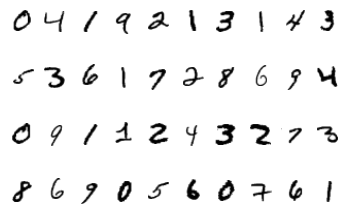

In [11]:
# Observing first 40 images
figure = plt.figure()
num_of_images = 40
for index in range(1, num_of_images + 1):
    plt.subplot(4, 10, index)
    plt.axis('off')
    plt.imshow(trainset.data[index],
               cmap='gray_r')

In [14]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

In [15]:
print(images.shape)
print(labels.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100])


### Building the model

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Declare all the layers for feature extraction
        self.features = nn.Sequential(nn.Conv2d(in_channels=1,
                                                out_channels=5,
                                                kernel_size=3,
                                                stride=1,
                                                padding=1), 
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(in_channels=5,
                                                out_channels=10,
                                                kernel_size=3,
                                                stride=1,
                                                padding=1), 
                                      nn.MaxPool2d(2, 2),
                                      nn.ReLU(inplace=True),
                                      nn.BatchNorm2d(10),
                                      nn.Conv2d(in_channels=10,
                                                out_channels=20,
                                                kernel_size=3,
                                                stride=1,
                                                padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.BatchNorm2d(20),
                                      nn.Conv2d(in_channels=20,
                                                out_channels=40,
                                                kernel_size=3,
                                                stride=1,
                                                padding=1),
                                      nn.MaxPool2d(2, 2),
                                      nn.ReLU(inplace=True),
                                      nn.BatchNorm2d(40))
        
        # Declare all the layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(7 * 7 * 40, 200),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(200, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 10))
        
    def forward(self, x):
      
        # Apply the feature extractor in the input
        x = self.features(x)
        
        # Squeeze the three spatial dimensions in one
        x = x.view(-1, 7 * 7 * 40)
        
        # Classify the images
        x = self.classifier(x)
        return x

In [17]:
# Instantiate the network
model = Net()
# Instantiate the cross-entropy loss
criterion = nn.CrossEntropyLoss()
# Instantiate the Adam optimizer
optimizer = optim.Adam(model.parameters(),
                       lr = 3e-4,
                       weight_decay= 0.001)

In [19]:
# batch_size, epoch and iteration
batch_size = 100
features_train = trainset.data.shape[0]
n_iters = 6000
num_epochs = n_iters/(features_train/batch_size)                                                                             
num_epochs = int(num_epochs)
print("number of epochs: " + str(num_epochs))

number of epochs: 10


In [20]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        train, labels = data
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate relu and cross entropy loss
        loss = criterion(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for i, data in enumerate(test_loader, 0):
                test, labels = data
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss value and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 600 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 600  Loss: 0.05991080403327942  Accuracy: 98.05000305175781 %
Iteration: 1200  Loss: 0.045197371393442154  Accuracy: 98.43000030517578 %
Iteration: 1800  Loss: 0.014218735508620739  Accuracy: 98.62000274658203 %
Iteration: 2400  Loss: 0.0210497435182333  Accuracy: 98.76000213623047 %
Iteration: 3000  Loss: 0.016273386776447296  Accuracy: 98.79000091552734 %
Iteration: 3600  Loss: 0.005812221672385931  Accuracy: 98.88999938964844 %
Iteration: 4200  Loss: 0.04637311398983002  Accuracy: 98.91000366210938 %
Iteration: 4800  Loss: 0.049399375915527344  Accuracy: 99.05000305175781 %
Iteration: 5400  Loss: 0.06593446433544159  Accuracy: 98.83000183105469 %
Iteration: 6000  Loss: 0.018614161759614944  Accuracy: 98.87000274658203 %


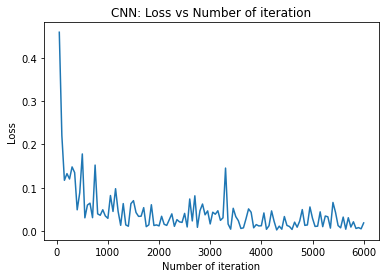

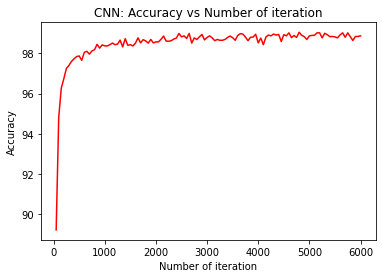

In [21]:
import matplotlib.pyplot as plt
# visualization of training loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()
# visualization of test accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()